In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
style.use('default') or plt.style.use('default')

colors_flux = sns.color_palette('viridis_r', n_colors=6).as_hex()
colors_sigma_R = sns.color_palette('inferno_r', n_colors=6).as_hex()


### Units used are as in Elmer/Ice:

MPa, a, m
 

In [2]:
# Conversion to Elmer/Ice units

yearinsec = 365.25*24*60*60
rhoi = 900.0/(1.0e6*yearinsec**2)
rhow = 1000.0/(1.0e6*yearinsec**2)
g = -9.8*yearinsec**2
n = 3.0
A = 4.6e-25*yearinsec*1.0e18


In [3]:
# Lists of fluxes, sigma values (in bed elevation equation) and simulation names
# To-do: clean this up once all sims have run

sims = ['Flux50Sigma1000',  'Flux50Sigma2000', 'Flux50Sigma3000', 'Flux50Sigma4000', 'Flux50Sigma5000',\
        'Flux100Sigma1000', 'Flux100Sigma2000', 'Flux100Sigma3000', 'Flux100Sigma4000', 'Flux100Sigma5000',\
        'Flux150Sigma1000', 'Flux150Sigma2000', 'Flux150Sigma3000', 'Flux150Sigma4000', 'Flux150Sigma5000',\
        'Flux200Sigma1000', 'Flux200Sigma2000', 'Flux200Sigma3000', 'Flux200Sigma4000', 'Flux200Sigma5000',\
        'Flux250Sigma1000', 'Flux250Sigma2000', 'Flux250Sigma3000', 'Flux250Sigma4000', 'Flux250Sigma5000', \
        'Flux300Sigma1000', 'Flux300Sigma2000', 'Flux300Sigma3000', 'Flux300Sigma4000', 'Flux300Sigma5000',\
        'Flux100NoPinningPoint', 'Flux200NoPinningPoint', 'Flux250NoPinningPoint', 'Flux300NoPinningPoint', \
        'Flux50Sigma4000_cyl', \
        'Flux100Sigma1000_cyl', 'Flux100Sigma3000_cyl', 'Flux100Sigma4000_cyl', \
        'Flux200Sigma1000_cyl', 'Flux200Sigma2000_cyl', 'Flux200Sigma3000_cyl', 'Flux200Sigma4000_cyl', 'Flux200Sigma5000_cyl',\
        'Flux250Sigma1000_cyl', 'Flux250Sigma2000_cyl', 'Flux250Sigma3000_cyl', 'Flux250Sigma4000_cyl', 'Flux250Sigma5000_cyl',\
        'Flux300Sigma2000_cyl', 'Flux300Sigma4000_cyl', 'Flux300Sigma5000_cyl']

#for i in fluxes:
#    for j in sigmas:
#        sims.append('Flux' + str(i) + 'Sigma' + str(j))

dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/StressWiderDomain/' + str(sim) + '.csv')
    

In [4]:
# Centre domain in the cylinder simualtions

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim]['Points:0'] = dfs[sim]['Points:0'] - 150000
        

In [5]:
# Calculate the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']
        

In [6]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim] = dfs[sim].sort_values(by=['Points:0', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    else:
        dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
        dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [7]:
# Calculate the hydrostatic pressure at a point if the ice shelf ended at that point

for sim in sims:
    dfs[sim]['hyd. pressure'] = [0] * len(dfs[sim])

for sim in sims:
    for i in range(len(dfs[sim])):
        if dfs[sim]['Points:2'][i] < 0.0:
            dfs[sim]['hyd. pressure'][i] = - rhow * g * dfs[sim]['Points:2'][i]
        else:
            dfs[sim]['hyd. pressure'][i] = 0.0
    
# Subtract the hydrostatic pressure from stress

for sim in sims:
    if sim.endswith('cyl'):
        dfs[sim]['stress 2 - hyd. p.'] = dfs[sim]['stress 2'] - dfs[sim]['hyd. pressure']
        dfs[sim]['dev stress 2 - hyd. p.'] = dfs[sim]['stress 2'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']
    else:
        dfs[sim]['stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure']
        dfs[sim]['dev stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']

In [8]:
# Function to vertically integrate data
# As input, it takes a dataframe, number of vertical nodes, variable and coordinate of interest

def VertInt(df, N, var, coord, TN = False, vel = False):
    if TN == True:
        min_z = dict.fromkeys(df[coord], 0)
        max_z = dict.fromkeys(df[coord], 0)
        thickness = dict.fromkeys(df[coord], 0)
        for i in range(len(df[coord])):
            if df["Points:2"][i] < min_z[df[coord][i]]:
                min_z[df[coord][i]] = df["Points:2"][i]
            if df["Points:2"][i] > max_z[df[coord][i]]:
                max_z[df[coord][i]] = df["Points:2"][i]
        for key in thickness.keys():
            thickness[key] = max_z[key] - min_z[key]
    field = dict.fromkeys(df[coord], 0)
    Coord = dict.fromkeys(df[coord], 0)
    v = dict.fromkeys(df[coord], 0)
    for i in df[coord]:
        Coord[i] += 1
    incorrect_coord_values = [k for k, v in Coord.items() if v != N]
    correct_coord_values = [k for k, v in Coord.items() if v == N]
    for i in incorrect_coord_values:
        Coord = {i:Coord[i] for i in Coord if i not in incorrect_coord_values}
        field = {i:field[i] for i in field if i not in incorrect_coord_values}
    df = df[~df[coord].isin(incorrect_coord_values)]
    df_height0 = df[df['height'] < 0.1]
    df_depth0 = df[df['pressure'] < 0.1]
    df_other = df[df['height'] > 0.1]
    df_other = df_other[df_other['pressure'] > 0.1]
    df_height0 = df_height0.reset_index(drop=True)
    df_depth0 = df_depth0.reset_index(drop=True)
    df_other = df_other.reset_index(drop=True)
    for i in range(len(df_other)):
        field[df_other[coord][i]] += df_other[var][i]
        if vel == True:
            v[df_other[coord][i]] += df_other['velocity:0'][i]
    for i in range(len(df_height0)):
        field[df_height0[coord][i]] += 0.5 * df_height0[var][i]
        if vel == True:
            v[df_height0[coord][i]] += df_height0['velocity:0'][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] += 0.5 * df_depth0[var][i]
        if vel == True:
            v[df_depth0[coord][i]] += df_depth0['velocity:0'][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] *= df_depth0['height'][i]
    field = {k: val / (N - 1) for k, val in field.items()}
    v = {k: val / (N - 1) for k, val in v.items()}
    if TN == True:
        for key in field.keys():
            field[key] = field[key] / thickness[key]
            if vel == True:
                field[key] = field[key] / (v[key]**(1/n))
    return field


In [9]:
# Calculate vertically-integrated fields of interest

stress1 = {}
devstress1 = {}
stress1hydp = {}
devstress1hydp = {}
hydp = {}

stress1_div_thickness = {}
devstress1_div_thickness = {}
stress1hydp_div_thickness = {}
devstress1hydp_div_thickness = {}
hydp_div_thickness = {}

stress1_div_thickness_u = {}
devstress1_div_thickness_u = {}
stress1hydp_div_thickness_u = {}
devstress1hydp_div_thickness_u = {}
hydp_div_thickness_u = {}

for sim in sims:
    if sim.endswith('cyl'):
        # Briefly let stress 1 be the dev stress 1 to check scaling
        stress1[sim] = VertInt(dfs[sim], 6, 'dev stress 2', 'Points:0')
        #stress1[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0')
        stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0')
        hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0')
        stress1_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0', True)
        stress1hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0', True)
        hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0', True)
        #stress1_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'stress 2', 'Points:0', True, True)
        #stress1hydp_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'stress 2 - hyd. p.', 'Points:0', True, True)
        #hydp_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:0', True, True)
        # Note: code not ready for the cylinder simulations
    else:
        # Briefly let stress 1 be the dev stress 1 to check scaling
        stress1[sim] = VertInt(dfs[sim], 6, 'dev stress 1', 'Points:1')
        #stress1[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1')
        stress1hydp[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1')
        hydp[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1')
        stress1_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1', True)
        stress1hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1', True)
        hydp_div_thickness[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1', True)
        stress1_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'stress 1', 'Points:1', True, True)
        stress1hydp_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'stress 1 - hyd. p.', 'Points:1', True, True)
        hydp_div_thickness_u[sim] = VertInt(dfs[sim], 6, 'hyd. pressure', 'Points:1', True, True)



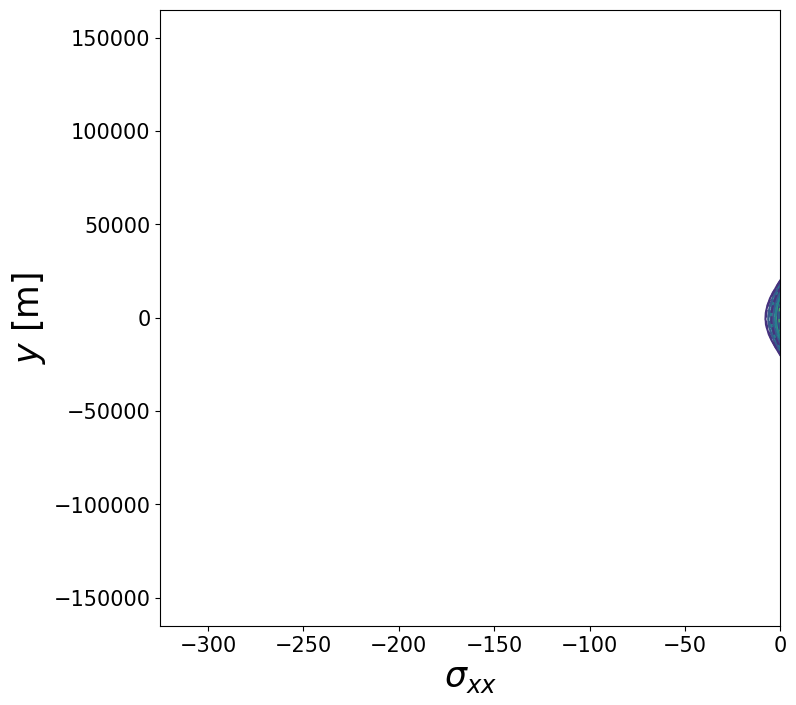

In [10]:
# Cylinder plot

colors2 = sns.color_palette('magma', n_colors=6).as_hex()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'cyl':
        if sim[4:6] == '50':
            ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[0], linestyle='dashed')
            #ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors2[0])
        else:
            ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1], linestyle='dashed')
            #ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors2[int(int(sim[4:6])/5)-1])
    else:
        if sim[4:6] == '50':
            ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[0])
            #ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[0])
        else:
            ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
            #ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors[int(int(sim[4:6])/5)-1])

ax.set_xlim([-325, 0])
ax.set_xlabel(r'$\sigma_{xx}$', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/cylinder_comparison.jpg', format='jpg', dpi=500, bbox_inches = "tight")


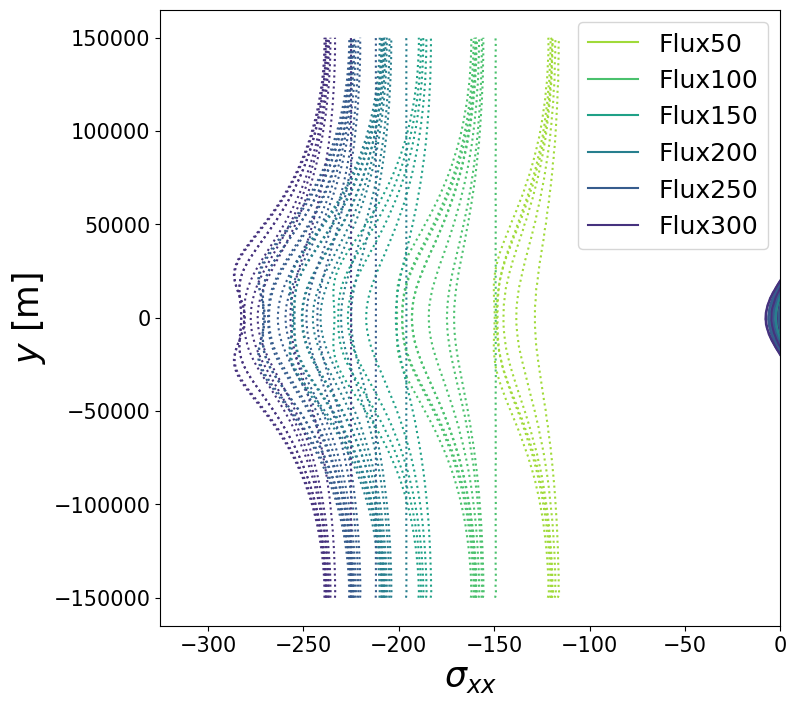

In [11]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'cyl':
        pass
    if sim[4:6] == '50':
        ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), color=colors_flux[0])
        ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), linestyle='dotted', color=colors_flux[0])
    else:
        ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(list(hydp[sim].values()), list(hydp[sim].keys()), linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1])
sim = 'Flux50Sigma1000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:6], color=colors_flux[0])
sim = 'Flux100Sigma1000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:7], color=colors_flux[int(int(sim[4:6])/5)-1])
sim = 'Flux150Sigma2000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:7], color=colors_flux[int(int(sim[4:6])/5)-1])
sim = 'Flux200Sigma1000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:7], color=colors_flux[int(int(sim[4:6])/5)-1]) 
sim = 'Flux250Sigma1000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:7], color=colors_flux[int(int(sim[4:6])/5)-1])
sim = 'Flux300Sigma2000'
ax.plot(list(stress1[sim].values()), list(stress1[sim].keys()), label=sim[:7], color=colors_flux[int(int(sim[4:6])/5)-1])

ax.set_xlim([-325, 0])
ax.set_xlabel(r'$\sigma_{xx}$', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='18')
fig.savefig('../Figures/stress1_wide_domain.jpg', format='jpg', dpi=500, bbox_inches = "tight")


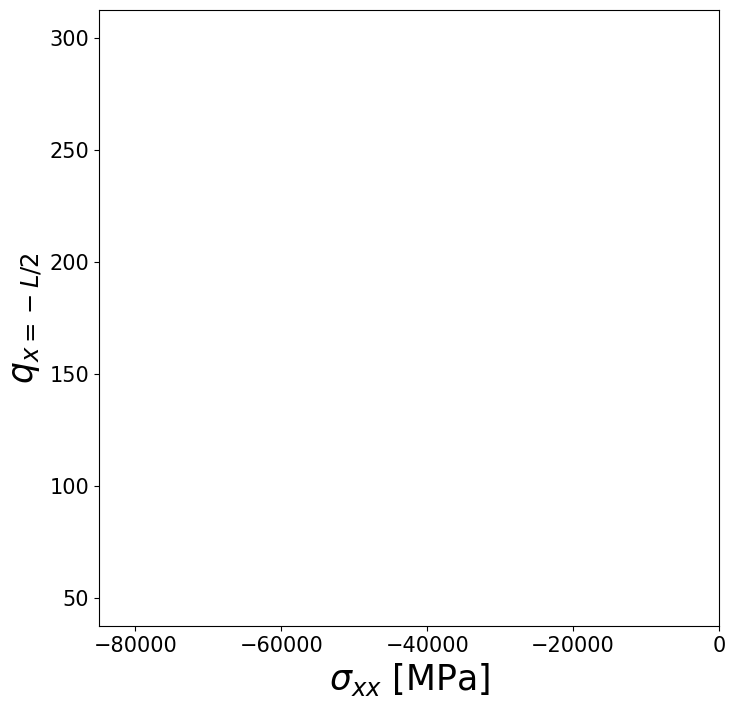

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        ax.scatter(300 * np.mean(list(stress1[sim].values())), int(sim[4:6]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)])
    else:
        ax.scatter(300 * np.mean(list(stress1[sim].values())), int(sim[4:7]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)])
ax.set_xlim([-85000, 0])
ax.set_xticks([-80000, -60000, -40000, -20000, 0])
ax.set_xlabel(r'$\sigma_{xx}$ [MPa]', size=25)
ax.set_ylabel(r'$q_{x=-L/2}$', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_integrated.jpg', format='jpg', dpi=500, bbox_inches = "tight")


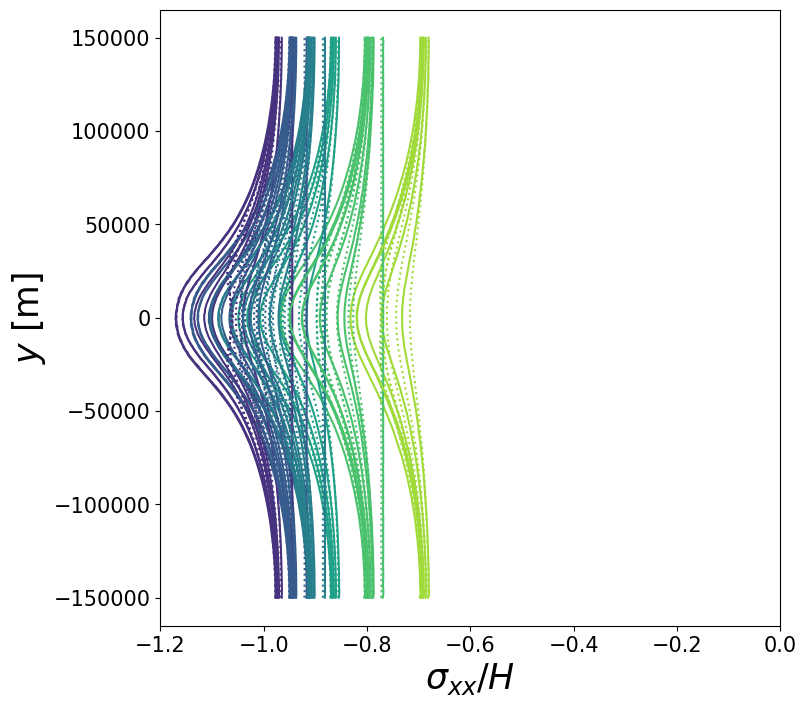

In [13]:
# Plot the 

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[4:6] == '50':
        ax.plot(list(stress1_div_thickness[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(list(hydp_div_thickness[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        ax.plot(list(stress1_div_thickness[sim].values()), list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(list(hydp_div_thickness[sim].values()), list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1]) 
ax.set_xlim([-1.2, 0])
ax.set_xlabel(r'$\sigma_{xx} / H$', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_div_thickness.jpg', format='jpg', dpi=500, bbox_inches = "tight")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


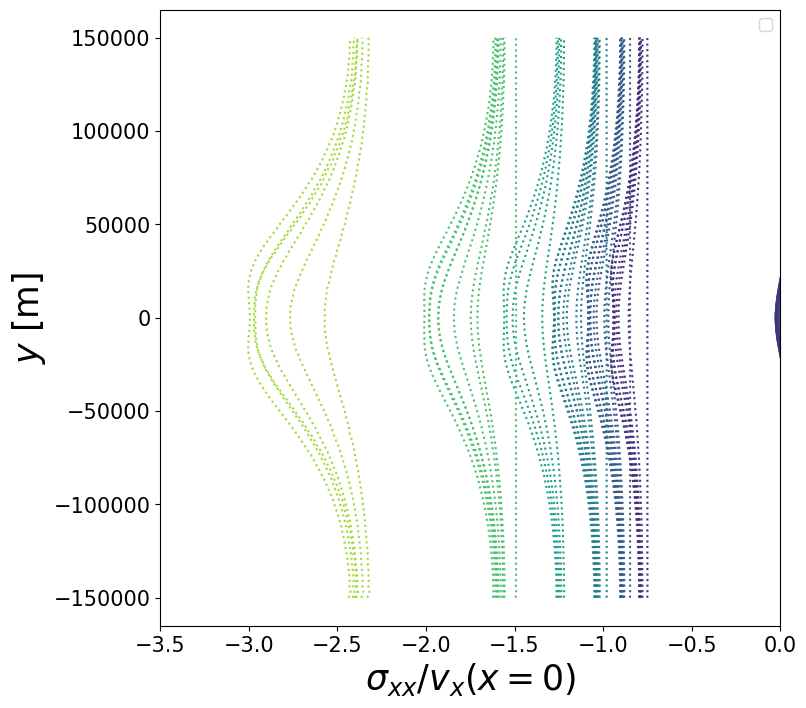

In [14]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[4:6]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[4:6]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), color=colors_flux[0])
        ax.plot(lst2, list(hydp[sim].keys()), linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[4:7]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[4:7]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1])   
ax.set_xlim([-3.5, 0])
ax.legend(fontsize='12')
ax.set_xlabel(r'$\sigma_{xx} / v_x(x=0)$', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_div_vel.jpg', format='jpg', dpi=500, bbox_inches = "tight")


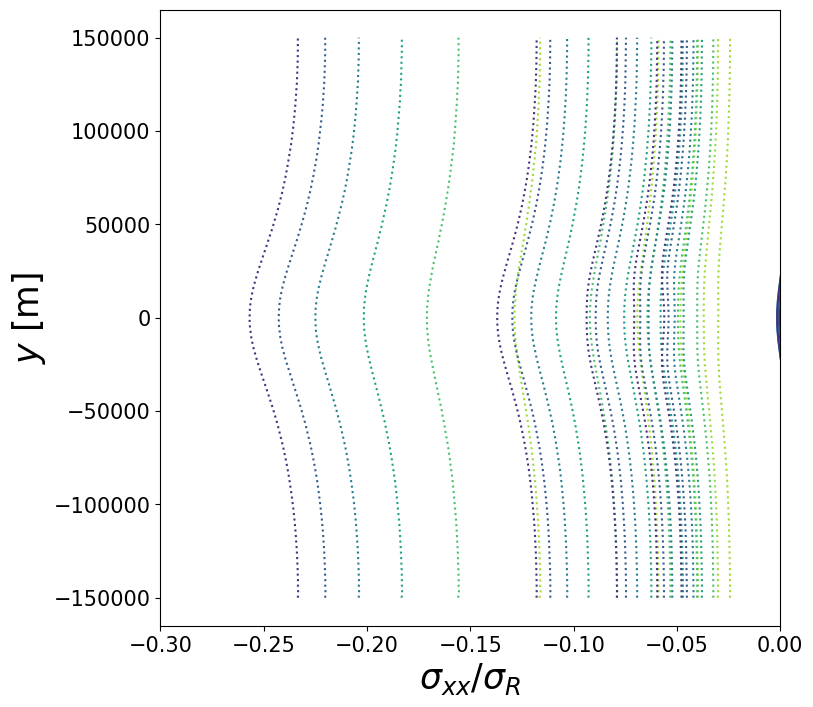

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[-4:]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[-4:]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / int(sim[-4:]) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / int(sim[-4:]) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1])
ax.set_xlim([-0.3, 0])
ax.set_xlabel(r'$\sigma_{xx} / \sigma_R$', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_div_sigma_R.jpg', format='jpg', dpi=500, bbox_inches = "tight")


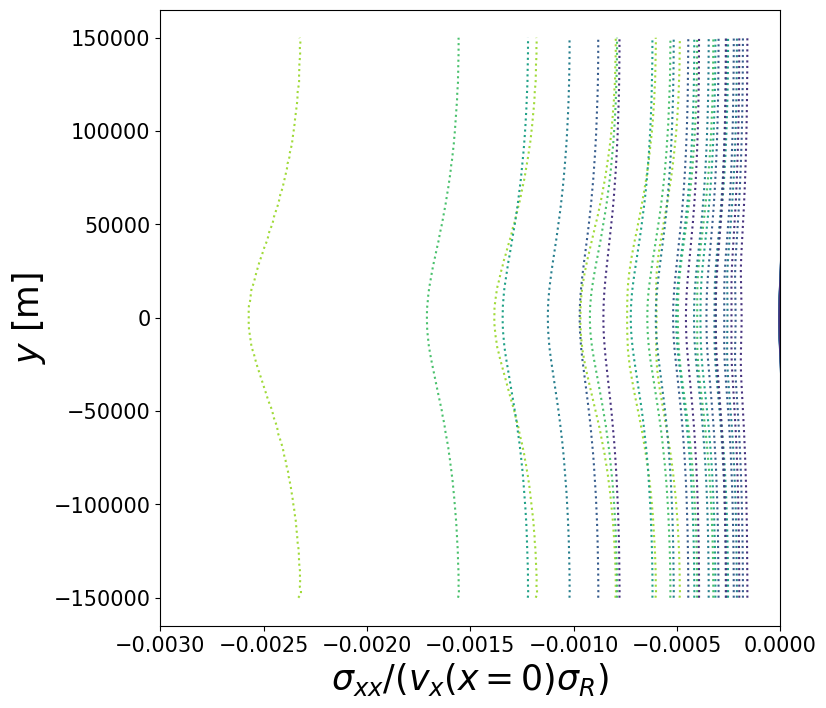

In [16]:
# Plot the stress in the x-direction 

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:]) * int(sim[4:6])) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / (int(sim[-4:]) * int(sim[4:6])) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:]) * int(sim[4:7])) for x in lst1]
        lst2 = list(hydp[sim].values())
        lst2 = [x / (int(sim[-4:]) * int(sim[4:7])) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim)
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1])
ax.set_xlim([-0.003, 0])
ax.set_xlabel(r'$\sigma_{xx} / (v_x(x=0) \sigma_R$)', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_div_vel_sigma_R.jpg', format='jpg', dpi=500, bbox_inches = "tight")


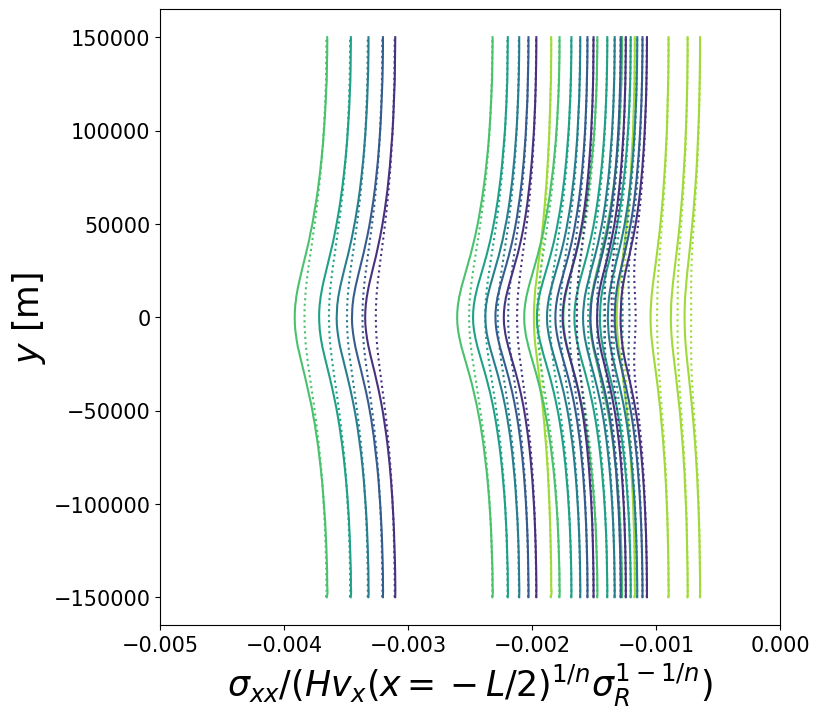

In [17]:
# Plot Ian's scaling approximation

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1_div_thickness[sim].values())
        lst1 = [ x / ((float(int(sim[4:6])) ** (1/3)) * float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness[sim].values())
        lst2 = [x / ((float(int(sim[4:6])) ** (1/3)) * float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1_div_thickness[sim].values())
        lst1 = [x / ((float(int(sim[4:6])) ** (1/3)) * float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness[sim].values())
        lst2 = [x / ((float(int(sim[4:6])) ** (1/3)) * float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.plot(lst1, list(stress1[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1]) 
ax.set_xlim([-0.005, 0])
ax.set_xlabel(r'$\sigma_{xx} / (H v_x(x=-L/2)^{1/n} \sigma_R^{1 - 1/n}$)', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_partial_scaling.jpg', format='jpg', dpi=500, bbox_inches = "tight")


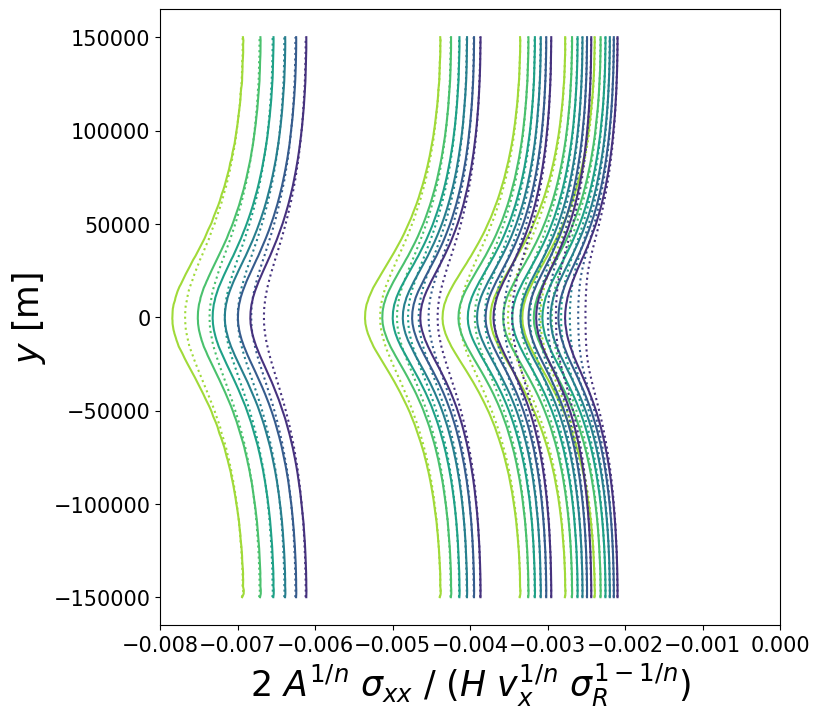

In [18]:


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.plot(lst1, list(stress1_div_thickness_u[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(lst2, list(hydp_div_thickness_u[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.plot(lst1, list(stress1_div_thickness_u[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp_div_thickness_u[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1]) 
ax.set_xlim([-0.008, 0])
ax.set_xlabel(r'$2$ $A^{1/n}$ $\sigma_{xx}$ / $(H$ $v_x^{1/n}$ $\sigma_R^{1 - 1/n}$)', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_scaling.jpg', format='jpg', dpi=500, bbox_inches = "tight")


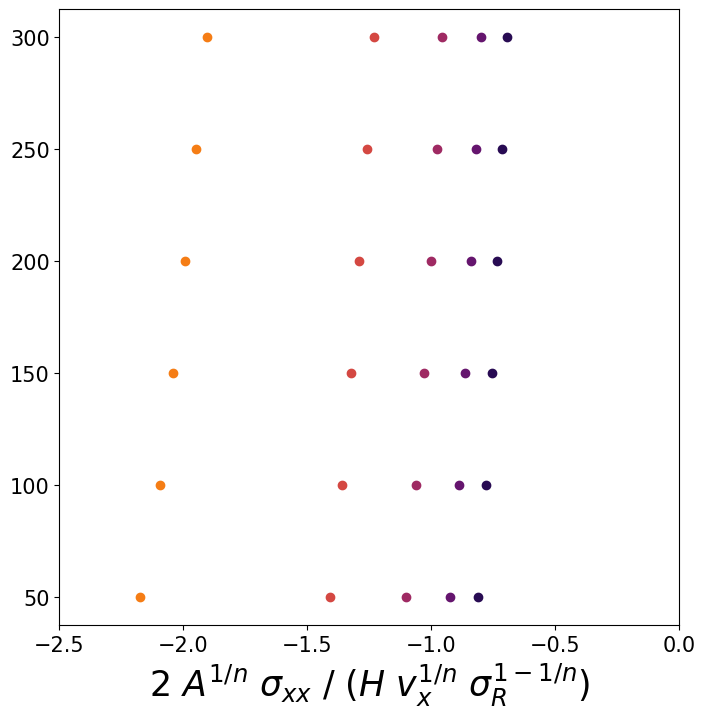

In [19]:


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.scatter(300 * np.mean(lst1), int(sim[4:6]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)])
    else:
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x / (float(int(sim[-4:]))**(1 - (1/3))) for x in lst2]
        ax.scatter(300 * np.mean(lst1), int(sim[4:7]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)]) 
ax.set_xlim([-2.5, 0])
ax.set_xlabel(r'$2$ $A^{1/n}$ $\sigma_{xx}$ / $(H$ $v_x^{1/n}$ $\sigma_R^{1 - 1/n}$)', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_scaling_integrated.jpg', format='jpg', dpi=500, bbox_inches = "tight")


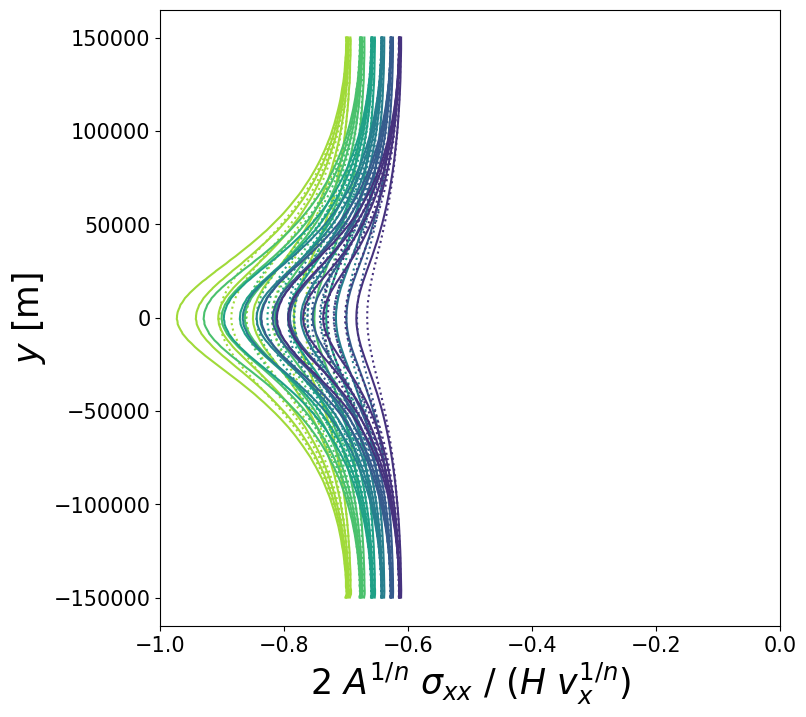

In [20]:


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x for x in lst2]
        ax.plot(lst1, list(stress1_div_thickness_u[sim].keys()), label=sim, color=colors_flux[0])
        ax.plot(lst2, list(hydp_div_thickness_u[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[0])
    else:
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x for x in lst2]
        ax.plot(lst1, list(stress1_div_thickness_u[sim].keys()), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1])
        ax.plot(lst2, list(hydp_div_thickness_u[sim].keys()), label=sim, linestyle='dotted', color=colors_flux[int(int(sim[4:6])/5)-1]) 
ax.set_xlim([-1, 0])
ax.set_xlabel(r'$2$ $A^{1/n}$ $\sigma_{xx}$ / $(H$ $v_x^{1/n}$)', size=25)
ax.set_ylabel(r'$y$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_scaling_without_sigma_R.jpg', format='jpg', dpi=500, bbox_inches = "tight")


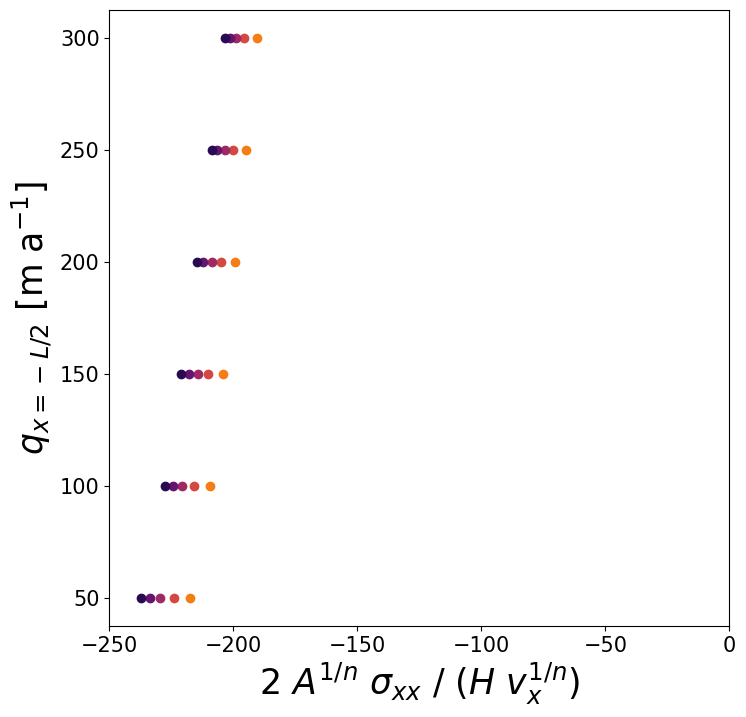

In [21]:


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x for x in lst2]
        ax.scatter(300 * np.mean(lst1), int(sim[4:6]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)])
    else:
        lst1 = list(stress1_div_thickness_u[sim].values())
        lst1 = [2 * (A**(1/n)) * x for x in lst1]
        lst2 = list(hydp_div_thickness_u[sim].values())
        lst2 = [2 * (A**(1/n)) * x for x in lst2]
        ax.scatter(300 * np.mean(lst1), int(sim[4:7]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)])
ax.set_xlim([-250, 0])
ax.set_xlabel(r'$2$ $A^{1/n}$ $\sigma_{xx}$ / $(H$ $v_x^{1/n}$)', size=25)
ax.set_ylabel(r'$q_{x=-L/2}$ [m a$^{-1}$]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/stress1_scaling_without_sigma_R_integrated.jpg', format='jpg', dpi=500, bbox_inches = "tight")


In [22]:
# Define arrays to store log values

num_sigma_R = 5
num_flux = 6
log_stress1 = np.full([num_sigma_R, num_flux], np.nan)
log_flux = np.full([num_sigma_R, num_flux], np.nan)
log_sigma_R = np.full([num_sigma_R, num_flux], np.nan)

for i in range(50, 350, 50):
    for j in range(1000, 6000, 1000):
        if 'Flux' + str(i) + 'Sigma' + str(j) in sims:
            log_stress1[int(j/1000 - 1)][int(i/50 - 1)] = np.log(- 300 * np.mean(list(stress1['Flux' + str(i) + 'Sigma' + str(j)].values())))
            log_flux[int(j/1000 - 1)][int(i/50 - 1)] = np.log(int(i))
            log_sigma_R[int(j/1000 - 1)][int(i/50 - 1)] = np.log(int(j))


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_35405/3851622403.py:12: RuntimeWarning: invalid value encountered in log
  log_stress1[int(j/1000 - 1)][int(i/50 - 1)] = np.log(- 300 * np.mean(list(stress1['Flux' + str(i) + 'Sigma' + str(j)].values())))


In [24]:


sigma_R_lines = []
flux_lines = []
sigma_R_slopes = []
flux_slopes = []

min_log_sigma_R, max_log_sigma_R = np.nanmin(log_sigma_R), np.nanmax(log_sigma_R)
min_log_flux, max_log_flux = np.nanmin(log_flux), np.nanmax(log_flux)

for i in range(6):
    idx = np.isfinite(log_stress1[:,i]) & np.isfinite(log_sigma_R[:,i])
    slope, intercept = np.polyfit(log_stress1[:,i][idx], log_sigma_R[:,i][idx], 1)
    sigma_R_lines.append([[(min_log_sigma_R - intercept) / slope, (max_log_sigma_R - intercept) / slope], [min_log_sigma_R, max_log_sigma_R]])
    sigma_R_slopes.append(1/slope)
    
for i in range(5):
    idx = np.isfinite(log_stress1[i,:]) & np.isfinite(log_flux[i,:])
    slope, intercept = np.polyfit(log_stress1[i,:][idx], log_flux[i,:][idx], 1)
    flux_lines.append([[(min_log_flux - intercept) / slope, (max_log_flux - intercept) / slope], [min_log_flux, max_log_flux]])
    flux_slopes.append(1/slope)


TypeError: expected non-empty vector for x

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_35405/189723517.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(int(sim[4:6])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_sigma_R[int(int(sim[-4:])/1000)])
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_35405/189723517.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(int(sim[4:7])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_sigma_R[int(int(sim[-4:])/1000)])


IndexError: list index out of range

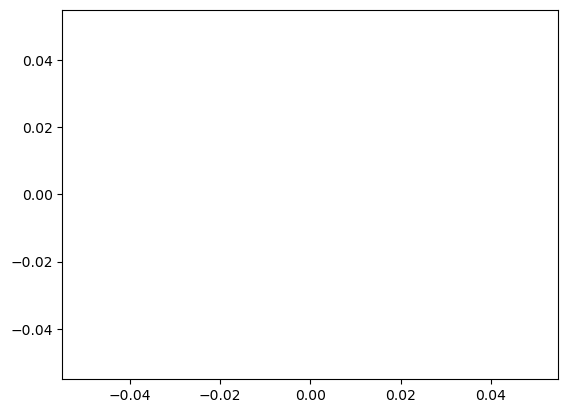

In [25]:
fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        ax.scatter(np.log(int(sim[4:6])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_sigma_R[int(int(sim[-4:])/1000)])
    else:
        ax.scatter(np.log(int(sim[4:7])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_sigma_R[int(int(sim[-4:])/1000)])
for i in range(5):
    ax.plot(flux_lines[i][1], flux_lines[i][0], color='lightgrey', zorder=0)
    
for i in range(1000, 6000, 1000):
    sim = 'Flux200Sigma' + str(i)
    ax.scatter(np.log(int(sim[4:7])), np.log(- 300 * np.mean(list(stress1[sim].values()))), label=r'$\sigma_R = $' + sim[-4:], color=colors_sigma_R[int(int(sim[-4:])/1000)])
    
ax.text(0.05, 0.9, r'$\bar{m} = $' + str(round(np.mean(flux_slopes), 4)), transform=ax.transAxes, size=15)
ax.set_xlabel(r'$log_e(v_{x=-L/2})$', size=25)
ax.set_ylabel(r'$log_e|\sigma_{xx}|$', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='15', loc='lower right')
fig.savefig('../Figures/log_sigma_R.jpg', format='jpg', dpi=500, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_35405/2719419654.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_flux[0])
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_35405/2719419654.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_flux[int(int(sim[4:7])/50)-1])


IndexError: list index out of range

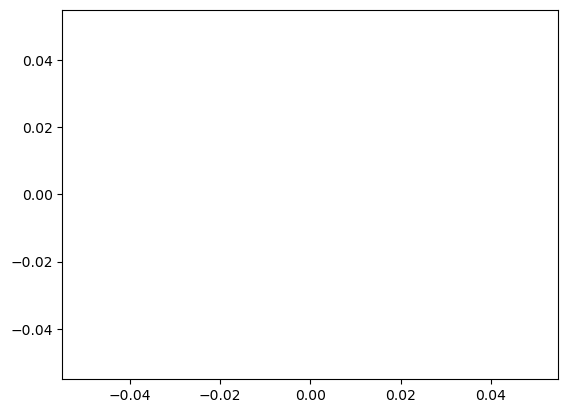

In [26]:
fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_flux[0])
    else:
        ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), color=colors_flux[int(int(sim[4:7])/50)-1]) 
for i in range(6):
    ax.plot(sigma_R_lines[i][1], sigma_R_lines[i][0], color='lightgrey', zorder=0)

for i in range(50, 350, 50):
    sim = 'Flux' + str(i) + 'Sigma2000'
    if sim[4:6] == '50':
        ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), label=r'$v_{x=-L/2} = $' + sim[4:6], color=colors_flux[0])
    else:
        ax.scatter(np.log(int(sim[-4:])), np.log(- 300 * np.mean(list(stress1[sim].values()))), label=r'$v_{x=-L/2} = $' + sim[4:7], color=colors_flux[int(int(sim[4:7])/50)-1])
    
ax.text(0.05, 0.92, r'$\bar{m} = $' + str(round(np.mean(sigma_R_slopes), 4)), transform=ax.transAxes, size=15)
ax.set_xlabel(r'$log_e(\sigma_R)$', size=25)
ax.set_ylabel(r'$log_e|\sigma_{xx}|$', size=25)
ax.set_xlim([6.5, 10])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
fig.savefig('../Figures/log_flux.jpg', format='jpg', dpi=500, bbox_inches = "tight")


In [ ]:


fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:])**round(np.mean(sigma_R_slopes), 4)) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[4:6]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)-1])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[-4:])**round(np.mean(sigma_R_slopes), 4)) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[4:7]), label=sim, color=colors_sigma_R[int(int(sim[-4:])/1000)-1]) 
ax.set_xlim([-50000, 0])
#ax.set_ylim([0, 350])
ax.set_xlabel(r'$\sigma_{xx}$ / ${\sigma_R}^{' + str(round(np.mean(sigma_R_slopes), 4)) + '}$', size=25)
ax.set_ylabel(r'$v_x(x = -L/2)$', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/div_sigma_R.jpg', format='jpg', dpi=500, bbox_inches = "tight")


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


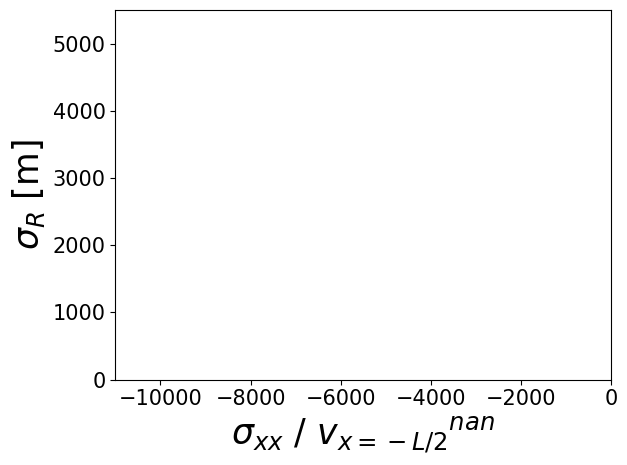

In [27]:


fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[4:6])**round(np.mean(flux_slopes), 4)) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / (int(sim[4:7])**round(np.mean(flux_slopes), 4)) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1]) 
ax.set_xlim([-11000, 0])
ax.set_ylim([0, 5500])
ax.set_xlabel(r'$\sigma_{xx}$ / ${v_{x=-L/2}}^{' + str(round(np.mean(flux_slopes), 4)) + '}$', size=25)
ax.set_ylabel(r'$\sigma_R$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/div_flux.jpg', format='jpg', dpi=500, bbox_inches = "tight")


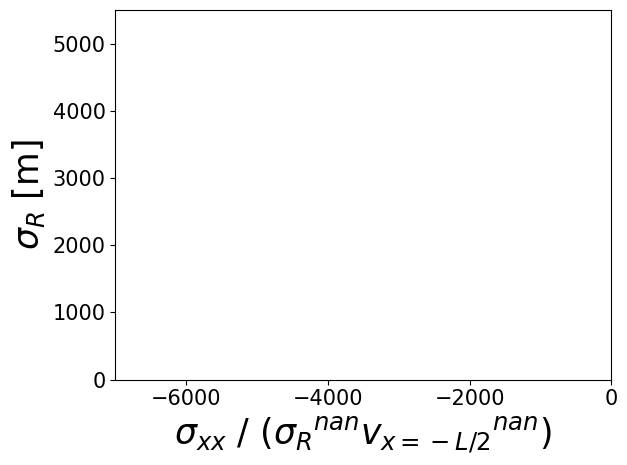

In [28]:


fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / ((int(sim[4:6])**round(np.mean(flux_slopes), 4)) * (int(sim[-4:])**round(np.mean(sigma_R_slopes), 4))) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / ((int(sim[4:7])**round(np.mean(flux_slopes), 4)) * (int(sim[-4:])**round(np.mean(sigma_R_slopes), 4))) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1]) 

ax.set_xticks([-6000, -4000, -2000, 0])         
#ax.set_xlim([-7000, 0])
ax.set_ylim([0, 5500])
ax.set_xlabel(r'$\sigma_{xx}$ / (${\sigma_R}^{' + str(round(np.mean(sigma_R_slopes), 4)) + '} {v_{x=-L/2}}^{' + str(round(np.mean(flux_slopes), 4)) + '})$', size=25)
ax.set_ylabel(r'$\sigma_R$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/div_sigma_R_flux.jpg', format='jpg', dpi=500, bbox_inches = "tight")


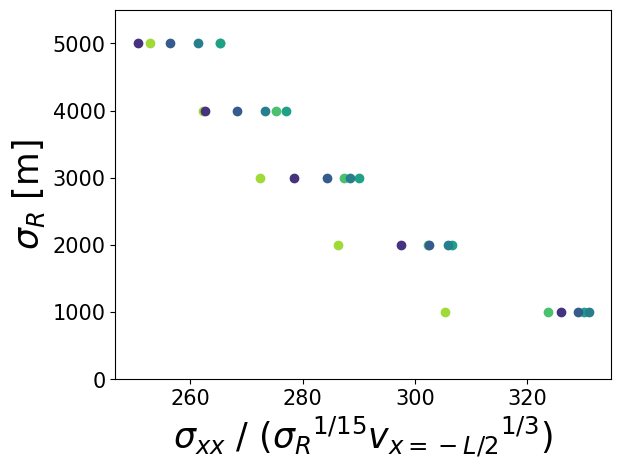

In [31]:


fig, ax = plt.subplots(1, 1)

for sim in sims:
    if sim[-3:] == 'int':
        pass
    elif sim[-3:] == 'cyl':
        pass
    elif sim[4:6] == '50':
        lst1 = list(stress1[sim].values())
        lst1 = [x / ((int(sim[4:6])**(1/3)) * (int(sim[-4:])**(1/15))) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[0])
    else:
        lst1 = list(stress1[sim].values())
        lst1 = [x / ((int(sim[4:7])**(1/3)) * (int(sim[-4:])**(1/15))) for x in lst1]
        ax.scatter(300 * np.mean(lst1), int(sim[-4:]), label=sim, color=colors_flux[int(int(sim[4:6])/5)-1]) 

#ax.set_xticks([-8000, -6000, -4000, -2000, 0])         
#ax.set_xlim([-8000, 0])
ax.set_ylim([0, 5500])
ax.set_xlabel(r'$\sigma_{xx}$ / (${\sigma_R}^{1/15} {v_{x=-L/2}}^{1/3})$', size=25)
ax.set_ylabel(r'$\sigma_R$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig('../Figures/div_n.jpg', format='jpg', dpi=500, bbox_inches = "tight")
